# How Do Humans and LLMs Compare in Reasoning with Gender and Stylistic Perturbations?

In [40]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.inter_rater import fleiss_kappa

In [41]:
# Set style
plt.style.use('seaborn')
plt.rcParams['font.family'] = 'Arial'

In [42]:
data = pd.read_csv('dataset.csv')
df = data[data['dataset'] != 'conversational']
df['id'] = df['context_id'].str.replace(r'^.*?-', '', regex=True)

/var/folders/fn/h8xn_2fd4fn64xfdn9xsf7gw0000gp/T/ipykernel_25249/2525939823.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['id'] = df['context_id'].str.replace(r'^.*?-', '', regex=True)


## Agreement Statistics

In [43]:
# Function to calculate three-way agreement for clinicians
def calculate_clinician_agreement(df, metric):
    cols = [f'{metric}_1', f'{metric}_2', f'{metric}_3']
    agreements = (df[cols[0]] == df[cols[1]]) & (df[cols[1]] == df[cols[2]])
    return agreements.mean(), agreements.std() / np.sqrt(len(agreements))

# Function to calculate model agreement
def calculate_model_agreement(df, metric):
    agreements = ((df[f'GPT4_{metric}'] == df[f'LLAMA3_{metric}']) & 
                 (df[f'LLAMA3_{metric}'] == df[f'LLAMA3-70_{metric}']) & 
                 (df[f'LLAMA3-70_{metric}'] == df[f'PALMYRA-MED_{metric}']))
    return agreements.mean(), agreements.std() / np.sqrt(len(agreements))

# Function to calculate Fleiss' kappa for clinicians
def calculate_clinician_kappa(df, metric):
    cols = [f'{metric}_1', f'{metric}_2', f'{metric}_3']
    ratings = df[cols].values
    n_categories = len(np.unique(ratings))
    n_subjects = len(ratings)
    n_raters = len(cols)
    
    agreement_matrix = np.zeros((n_subjects, n_categories))
    for i in range(n_subjects):
        for j in range(n_raters):
            agreement_matrix[i, ratings[i,j]-1] += 1
    
    kappa = fleiss_kappa(agreement_matrix)
    
    # Calculate standard error (using bootstrap)
    n_bootstraps = 1000
    kappas = []
    for _ in range(n_bootstraps):
        boot_indices = np.random.choice(n_subjects, n_subjects, replace=True)
        boot_matrix = agreement_matrix[boot_indices]
        kappas.append(fleiss_kappa(boot_matrix))
    sem = np.std(kappas)
    
    return kappa, sem

# Function to calculate Fleiss' kappa for models
def calculate_model_kappa(df, metric):
    model_cols = [f'GPT4_{metric}', f'LLAMA3_{metric}', 
                 f'LLAMA3-70_{metric}', f'PALMYRA-MED_{metric}']
    ratings = df[model_cols].values
    
    n_categories = len(np.unique(ratings))
    n_subjects = len(ratings)
    n_raters = len(model_cols)
    
    agreement_matrix = np.zeros((n_subjects, n_categories))
    for i in range(n_subjects):
        for j in range(n_raters):
            agreement_matrix[i, ratings[i,j]-1] += 1
    
    kappa = fleiss_kappa(agreement_matrix)
    
    # Calculate standard error (using bootstrap)
    n_bootstraps = 1000
    kappas = []
    for _ in range(n_bootstraps):
        boot_indices = np.random.choice(n_subjects, n_subjects, replace=True)
        boot_matrix = agreement_matrix[boot_indices]
        kappas.append(fleiss_kappa(boot_matrix))
    sem = np.std(kappas)
    
    return kappa, sem

In [44]:
# Prepare data
metrics = ['MANAGE', 'VISIT', 'RESOURCE']
dataset_ids = [1, 2, 3, 4, 5]  # Baseline, Gender-Swapped, Gender-Removed, Uncertain, Colorful
dataset_id_labels = {
    1: 'Baseline',
    2: 'Gender-Swapped',
    3: 'Gender-Removed',
    4: 'Uncertain',
    5: 'Colorful'
}

# Store results for both agreement and kappa
agreement_results = []
kappa_results = []

# Calculate metrics for each combination
for dataset_id in dataset_ids:
    subset_df = df[df['dataset_id'] == dataset_id]
    
    # Calculate for clinicians
    for metric in metrics:
        # Calculate agreement
        mean, sem = calculate_clinician_agreement(subset_df, metric)
        agreement_results.append({
            'Dataset ID': dataset_id,
            'Dataset ID Label': dataset_id_labels[dataset_id],
            'Metric': metric,
            'Type': 'Clinician',
            'Value': mean,
            'SEM': sem
        })
        
        # Calculate kappa
        kappa, sem = calculate_clinician_kappa(subset_df, metric)
        kappa_results.append({
            'Dataset ID': dataset_id,
            'Dataset ID Label': dataset_id_labels[dataset_id],
            'Metric': metric,
            'Type': 'Clinician',
            'Value': kappa,
            'SEM': sem
        })
    
    # Calculate for models
    for metric in metrics:
        # Calculate agreement
        mean, sem = calculate_model_agreement(subset_df, metric)
        agreement_results.append({
            'Dataset ID': dataset_id,
            'Dataset ID Label': dataset_id_labels[dataset_id],
            'Metric': metric,
            'Type': 'Models',
            'Value': mean,
            'SEM': sem
        })
        
        # Calculate kappa
        kappa, sem = calculate_model_kappa(subset_df, metric)
        kappa_results.append({
            'Dataset ID': dataset_id,
            'Dataset ID Label': dataset_id_labels[dataset_id],
            'Metric': metric,
            'Type': 'Models',
            'Value': kappa,
            'SEM': sem
        })

# Convert results to DataFrames
agreement_df = pd.DataFrame(agreement_results)
kappa_df = pd.DataFrame(kappa_results)

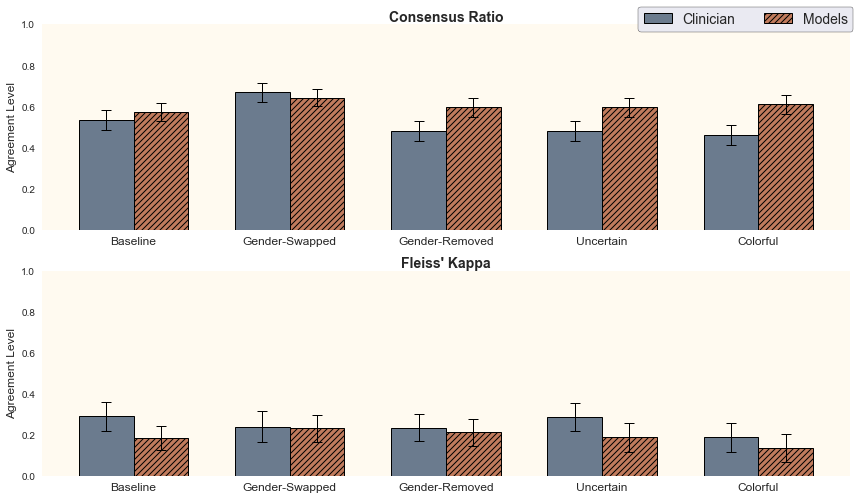

In [45]:

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7))  # Changed from (12, 10) to (15, 6)

# Define colors
colors = ['#6B7B8E', '#C17B5D']  # Rust orange for Clinician, gray for Models

# Function to create bar plot
def create_bar_plot(ax, df, title, ylabel):
    dataset_ids = df['Dataset ID Label'].unique()
    types = df['Type'].unique()
    x = np.arange(len(dataset_ids))
    width = 0.35

    for i, type_ in enumerate(types):
        type_data = df[df['Type'] == type_]
        values = type_data.groupby('Dataset ID Label')['Value'].mean()
        errors = type_data.groupby('Dataset ID Label')['SEM'].mean()
        offset = (i - 0.5) * width
        bars = ax.bar(x + offset, values, width, label=type_,
              color=colors[i], edgecolor='black', linewidth=1,
              hatch='////' if type_ == 'Models' else None)  # Add hatching only for Models
        
        # Add error bars
        ax.errorbar(x + offset, values, yerr=errors, fmt='none', color='black', 
                   capsize=5, capthick=1, elinewidth=1)

    ax.set_title(title, fontsize=14, pad=2, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_ylim(0, 1)
    ax.set_xticks(x)
    ax.set_xticklabels(dataset_ids, ha='center', fontsize=12)
    ax.grid(False)
    ax.set_facecolor('#FFFAF0') # Changed pad from 10 to 5
    
    # Add axes lines
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1)

# Create both plots
create_bar_plot(ax1, agreement_df, 'Consensus Ratio', 
                'Agreement Level')
create_bar_plot(ax2, kappa_df, 'Fleiss\' Kappa', 
                'Agreement Level')

# Add single legend at the top
handles, labels = ax1.get_legend_handles_labels()

legend = fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 1), ncol=2, fontsize=14, frameon=True, edgecolor='black', framealpha=1)

# Adjust layout
plt.tight_layout()

plt.subplots_adjust(hspace=0.2)

plt.show()

## Average Treatment Rate

In [46]:
import numpy as np
# Function to calculate mean clinician score
def calculate_clinician_mean(df, metric):
    cols = [f'{metric}_1', f'{metric}_2', f'{metric}_3']
    return df[cols].mean(axis=1).mean(), df[cols].mean(axis=1).std() / np.sqrt(len(df))

# Function to calculate model mean
def calculate_model_mean(df, metric, model):
    return df[f'{model}_{metric}'].mean(), df[f'{model}_{metric}'].std() / np.sqrt(len(df))

# Prepare data
metrics = ['MANAGE', 'VISIT', 'RESOURCE']
models = ['GPT4', 'LLAMA3', 'LLAMA3-70', 'PALMYRA-MED']
dataset_ids = [1, 2, 3, 4, 5]
dataset_id_labels = {
    1: 'Baseline',
    2: 'Gender-Swapped',
    3: 'Gender-Removed',
    4: 'Uncertain',
    5: 'Colorful'
}

# Store results
results = []
for dataset_id in dataset_ids:
    subset_df = df[df['dataset_id'] == dataset_id]
    
    # Clinician scores
    for metric in metrics:
        mean, sem = calculate_clinician_mean(subset_df, metric)
        results.append({
            'Dataset ID': dataset_id,
            'Dataset ID Label': dataset_id_labels[dataset_id],
            'Metric': metric,
            'Type': 'Clinician',
            'Value': mean,
            'SEM': sem
        })

    # Model scores
    for model in models:
        for metric in metrics:
            mean, sem = calculate_model_mean(subset_df, metric, model)
            results.append({
                'Dataset ID': dataset_id,
                'Dataset ID Label': dataset_id_labels[dataset_id],
                'Metric': metric,
                'Type': model,
                'Value': mean,
                'SEM': sem
            })

# Convert to DataFrame
results_df = pd.DataFrame(results)


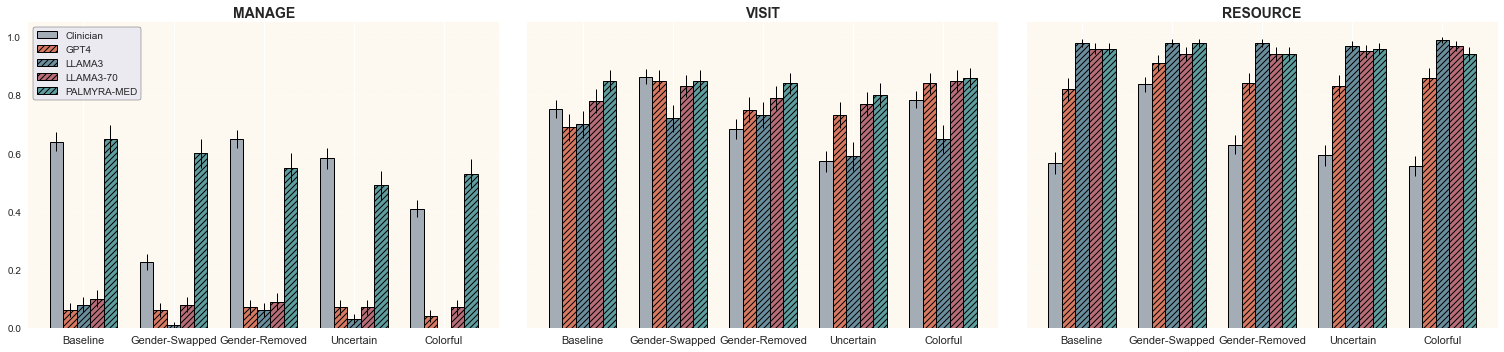

In [47]:
# Create figure with three side-by-side subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 5), sharey=True)

# Define clean, modern colors
colors = {
    'Clinician': '#A4ACB5',
    'GPT4': '#D77A61',
    'LLAMA3': '#6B8E9E',
    'LLAMA3-70': '#B76E79',
    'PALMYRA-MED': '#5F9EA0'
}

# Define bar plot function
def create_bar_plot(ax, df, metric, title):
    dataset_ids = df['Dataset ID Label'].unique()
    types = df['Type'].unique()
    x = np.arange(len(dataset_ids))
    width = 0.15

    for i, type_ in enumerate(types):
        type_data = df[df['Type'] == type_]
        values = type_data.groupby('Dataset ID Label')['Value'].mean()
        errors = type_data.groupby('Dataset ID Label')['SEM'].mean()
        offset = (i - 2) * width
        bars = ax.bar(x + offset, values, width,
                      label=type_,
                      color=colors[type_],
                      edgecolor='black',
                      linewidth=1,
                      hatch='////' if type_ != 'Clinician' else None)
        
        # Error bars
        ax.errorbar(x + offset, values, yerr=errors, fmt='none', color='black',
                    capsize=4, elinewidth=1)

    ax.set_title(title, fontsize=14, weight='bold', pad=5)
    ax.set_xticks(x)
    ax.set_xticklabels(dataset_ids, fontsize=11)
    ax.set_ylim(0, 1.05)
    ax.set_facecolor('#FDF8F0')
    ax.yaxis.grid(True, linestyle='--', alpha=0.5)
    ax.set_axisbelow(True)

    # Clean up spines
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.axhline(y=0, color='black', linewidth=1)

# Create each subplot
create_bar_plot(ax1, results_df[results_df['Metric'] == 'MANAGE'], 'MANAGE', 'MANAGE')
create_bar_plot(ax2, results_df[results_df['Metric'] == 'VISIT'], 'VISIT', 'VISIT')
create_bar_plot(ax3, results_df[results_df['Metric'] == 'RESOURCE'], 'RESOURCE', 'RESOURCE')

# Single inside legend in ax1
ax1.legend(loc='upper left', fontsize=10, frameon=True, framealpha=0.95, edgecolor='black')

# Final layout tweaks
plt.tight_layout()
plt.subplots_adjust(wspace=0.06)

plt.show()


## Mutual Information

In [62]:
# Function to calculate mutual information for clinicians
def calculate_clinician_mi(baseline_df, current_df, metric):
    # Merge dataframes on 'id' to ensure we're comparing the same cases
    merged_df = pd.merge(baseline_df, current_df, on='id', suffixes=('_base', '_curr'))
    
    # Get columns for baseline and current
    cols_base = [f'{metric}_1_base', f'{metric}_2_base', f'{metric}_3_base']
    cols_curr = [f'{metric}_1_curr', f'{metric}_2_curr', f'{metric}_3_curr']
    
    # Calculate majority vote for each case
    baseline_majority = merged_df[cols_base].mode(axis=1).iloc[:, 0]
    current_majority = merged_df[cols_curr].mode(axis=1).iloc[:, 0]

    # Reset index to ensure unique indices
    baseline_majority = baseline_majority.reset_index(drop=True)
    current_majority = current_majority.reset_index(drop=True)

    
    # Calculate mutual information
    def calculate_mi(x, y):
        # Create joint distribution
        joint = pd.crosstab(x, y, normalize=True)
        # Calculate marginal distributions
        p_x = joint.sum(axis=1)
        p_y = joint.sum(axis=0)
        # Calculate mutual information
        mi = 0
        for i in joint.index:
            for j in joint.columns:
                if joint.loc[i,j] > 0:
                    mi += joint.loc[i,j] * np.log2(joint.loc[i,j] / (p_x[i] * p_y[j]))
        return mi
    
    mi = calculate_mi(baseline_majority, current_majority)
    
    # Calculate standard error using bootstrap
    n_bootstraps = 1000
    mis = []
    for _ in range(n_bootstraps):
        indices = np.random.choice(len(baseline_majority), len(baseline_majority), replace=True)
        boot_mi = calculate_mi(
            baseline_majority.iloc[indices].reset_index(drop=True),
            current_majority.iloc[indices].reset_index(drop=True)
        )
        mis.append(boot_mi)

    sem = np.std(mis)
    
    return mi, sem

# Function to calculate mutual information for a model
def calculate_model_mi(baseline_df, current_df, metric, model):
    # Merge dataframes on 'id' to ensure we're comparing the same cases
    merged_df = pd.merge(baseline_df, current_df, on='id', suffixes=('_base', '_curr'))
    
    # Reset index to ensure unique indices
    baseline_values = merged_df[f'{model}_{metric}_base'].reset_index(drop=True)
    current_values = merged_df[f'{model}_{metric}_curr'].reset_index(drop=True)
    
    # Calculate mutual information
    def calculate_mi(x, y):
        joint = pd.crosstab(x, y, normalize=True)
        p_x = joint.sum(axis=1)
        p_y = joint.sum(axis=0)
        mi = 0
        for i in joint.index:
            for j in joint.columns:
                if joint.loc[i,j] > 0:
                    mi += joint.loc[i,j] * np.log2(joint.loc[i,j] / (p_x[i] * p_y[j]))
        return mi
    
    mi = calculate_mi(baseline_values, current_values)
    
    # Calculate standard error using bootstrap
    n_bootstraps = 1000
    mis = []
    for _ in range(n_bootstraps):
        indices = np.random.choice(len(baseline_values), len(baseline_values), replace=True)
        boot_mi = calculate_mi(baseline_values.iloc[indices], current_values.iloc[indices])
        mis.append(boot_mi)
    sem = np.std(mis)
    
    return mi, sem


# Function to calculate shift rate for clinicians
def calculate_clinician_shift(baseline_df, current_df, metric):
    # Merge dataframes on 'id' to ensure we're comparing the same cases
    merged_df = pd.merge(baseline_df, current_df, on='id', suffixes=('_base', '_curr'))
    
    # Get columns for baseline and current
    cols_base = [f'{metric}_1_base', f'{metric}_2_base', f'{metric}_3_base']
    cols_curr = [f'{metric}_1_curr', f'{metric}_2_curr', f'{metric}_3_curr']
    
    # Calculate majority vote for each case
    baseline_majority = merged_df[cols_base].mode(axis=1)[0]  # Get most common value
    current_majority = merged_df[cols_curr].mode(axis=1)[0]   # Get most common value
    
    # Calculate proportion of cases where the majority vote changed
    shifts = (baseline_majority != current_majority).mean()
    sem = np.sqrt(shifts * (1 - shifts) / len(baseline_majority))
    return shifts, sem

# Function to calculate shift rate for a model
def calculate_model_shift(baseline_df, current_df, metric, model):
    # Merge dataframes on 'id' to ensure we're comparing the same cases
    merged_df = pd.merge(baseline_df, current_df, on='id', suffixes=('_base', '_curr'))
    
    # Calculate proportion of cases where the response changed
    shifts = (merged_df[f'{model}_{metric}_base'] != merged_df[f'{model}_{metric}_curr']).mean()
    sem = np.sqrt(shifts * (1 - shifts) / len(merged_df))
    return shifts, sem


# Prepare data
metrics = ['MANAGE', 'VISIT', 'RESOURCE']
models = ['GPT4', 'LLAMA3', 'LLAMA3-70', 'PALMYRA-MED']
dataset_ids = [2, 3, 4, 5]  # Excluding baseline (1)
dataset_id_labels = {
    2: 'Gender-Swapped',
    3: 'Gender-Removed',
    4: 'Uncertain',
    5: 'Colorful'
}

# Store results
results = []

# Get baseline data
baseline_df = df[df['dataset_id'] == 1]

# Calculate shift rates for each combination
for dataset_id in dataset_ids:
    current_df = df[df['dataset_id'] == dataset_id]
    
    # Calculate for clinicians
    for metric in metrics:
        shifts, sem = calculate_clinician_shift(baseline_df, current_df, metric)
        results.append({
            'Dataset ID': dataset_id,
            'Dataset ID Label': dataset_id_labels[dataset_id],
            'Metric': metric,
            'Type': 'Clinician',
            'Value': shifts,
            'SEM': sem
        })
    
    # Calculate for each model
    for model in models:
        for metric in metrics:
            shifts, sem = calculate_model_shift(baseline_df, current_df, metric, model)
            results.append({
                'Dataset ID': dataset_id,
                'Dataset ID Label': dataset_id_labels[dataset_id],
                'Metric': metric,
                'Type': model,
                'Value': shifts,
                'SEM': sem
            })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Define colors
colors = ['#7D9F8B', '#C17B5D', '#6B8E9E', '#B76E79', '#5F9EA0']  # Medium-tone colors


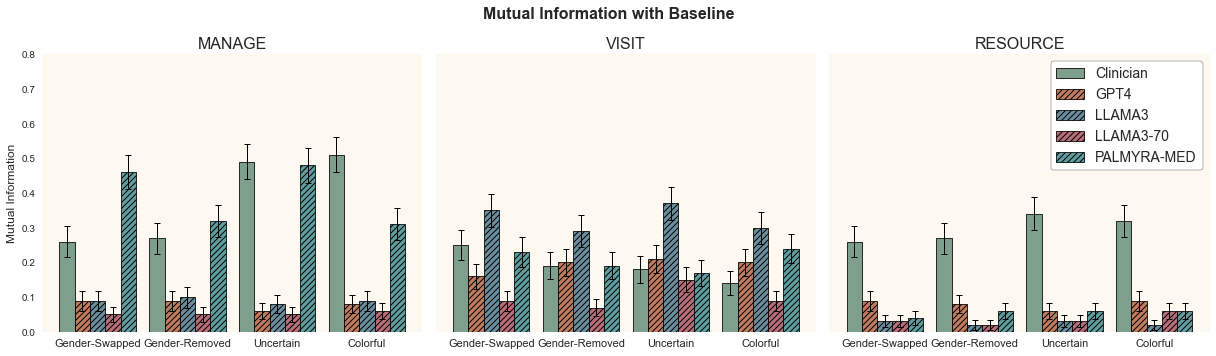

In [63]:

# Updated plot style
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'Arial'

# Refined function
def create_bar_plot(ax, df, metric, title):
    dataset_ids = df['Dataset ID Label'].unique()
    types = df['Type'].unique()
    x = np.arange(len(dataset_ids))
    width = 0.17

    for i, type_ in enumerate(types):
        type_data = df[df['Type'] == type_]
        values = type_data.groupby('Dataset ID Label')['Value'].mean().reindex(dataset_ids)
        errors = type_data.groupby('Dataset ID Label')['SEM'].mean().reindex(dataset_ids)
        offset = (i - 2) * width

        bars = ax.bar(x + offset, values, width, label=type_,
                      color=colors[i % len(colors)],
                      edgecolor='black', linewidth=0.8,
                      hatch='////' if type_ != 'Clinician' else None)

        ax.errorbar(x + offset, values, yerr=errors, fmt='none', color='black', 
                    capsize=3, capthick=1, elinewidth=1)

    ax.set_title(title, fontsize=16)
    ax.set_ylabel('Mutual Information', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(dataset_ids, fontsize=11)
    ax.set_ylim(0, 0.8)  # Mutual information is between 0 and 1

    ax.set_facecolor('#FDF8F0')
    ax.yaxis.grid(True, linestyle='--', alpha=0.5)
    ax.grid(False)
    ax.set_axisbelow(True)

    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.axhline(y=0, color='black', linewidth=1)

    # Minimal, clean spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')

# Create figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 5))

# Create plots for each metric
create_bar_plot(ax1, results_df[results_df['Metric'] == 'MANAGE'], 'MANAGE', 'MANAGE')
create_bar_plot(ax2, results_df[results_df['Metric'] == 'VISIT'], 'VISIT', 'VISIT')
create_bar_plot(ax3, results_df[results_df['Metric'] == 'RESOURCE'], 'RESOURCE', 'RESOURCE')

# Unified legend
handles, labels = ax1.get_legend_handles_labels()
ax3.legend(loc='upper right', fontsize=14, frameon=True, framealpha=0.95, edgecolor='black')

# Clean up layout
for ax in [ax1, ax2, ax3]:
    ax.label_outer()

plt.subplots_adjust(hspace=0.5)
plt.suptitle("Mutual Information with Baseline", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()